In [ ]:
!pip install svgpathtools numpy moondream-station moondream

# Instance Segmentation COCO Format from Moondream Format

Detecting...
Found 6 objects.
Segmenting...
✅ Saved 6 annotations.

Visualizing Result...


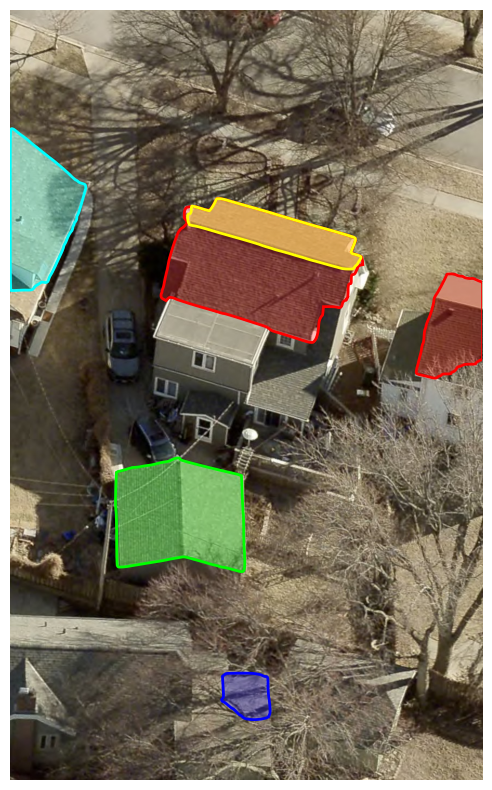

In [ ]:
import moondream as md
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json
from svgpathtools import parse_path
import os


api_key = "abcd"
model = md.vl(api_key=api_key)

image_path = "/content/image_1.jpg"

if not os.path.exists(image_path):
    print(f"❌ Image not found at {image_path}")
else:
    image = Image.open(image_path)
    w, h = image.size

    # Detect Points first
    print("Detecting...")
    point_result = model.point(image, "Roof")
    points = point_result["points"]
    print(f"Found {len(points)} objects.")

    segments = []
    print("Segmenting...")
    for point in points:
        result = model.segment(
            image,
            "Roof", # Or "Roof parts with damage" as per your need
            spatial_refs=[[point["x"], point["y"]]]
        )
        segments.append(result)

    def svg_path_to_coco_polygon(path_str, bbox_norm, img_w, img_h, num_samples=30):
        """
        Converts SVG path to Pixels using the Bounding Box as the reference frame.
        """
        try:
            box_x = bbox_norm['x_min'] * img_w
            box_y = bbox_norm['y_min'] * img_h
            box_w = (bbox_norm['x_max'] - bbox_norm['x_min']) * img_w
            box_h = (bbox_norm['y_max'] - bbox_norm['y_min']) * img_h

            path = parse_path(path_str)
            poly_points = []

            for segment in path:
                for t in np.linspace(0, 1, num_samples):
                    point = segment.point(t)

                    abs_x = box_x + (point.real * box_w)
                    abs_y = box_y + (point.imag * box_h)

                    abs_x = min(max(abs_x, 0), img_w)
                    abs_y = min(max(abs_y, 0), img_h)

                    poly_points.extend([round(abs_x, 2), round(abs_y, 2)])

            return [poly_points]
        except Exception as e:
            print(f"Error parsing segment: {e}")
            return []

    def calculate_area(segmentation):
        try:
            if not segmentation: return 0
            poly = np.array(segmentation[0]).reshape(-1, 2)
            x = poly[:, 0]
            y = poly[:, 1]
            return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))
        except:
            return 0


    coco_output = {
        "info": {"description": "Roof Dataset", "year": 2025},
        "categories": [{"id": 1, "name": "roof", "supercategory": "building"}],
        "images": [{"id": 1, "width": w, "height": h, "file_name": os.path.basename(image_path)}],
        "annotations": []
    }

    ann_id = 1
    for seg in segments:
        segmentation = svg_path_to_coco_polygon(seg['path'], seg['bbox'], w, h)

        if not segmentation or len(segmentation[0]) < 6: continue

        b = seg['bbox']
        abs_bbox = [
            round(b['x_min'] * w, 2),
            round(b['y_min'] * h, 2),
            round((b['x_max'] - b['x_min']) * w, 2),
            round((b['y_max'] - b['y_min']) * h, 2)
        ]

        coco_output["annotations"].append({
            "id": ann_id,
            "image_id": 1,
            "category_id": 1,
            "segmentation": segmentation,
            "area": calculate_area(segmentation),
            "bbox": abs_bbox,
            "iscrowd": 0
        })
        ann_id += 1

    # Save
    with open("coco_annotations.json", "w") as f:
        json.dump(coco_output, f)
    print(f"✅ Saved {len(coco_output['annotations'])} annotations.")

    print("\nVisualizing Result...")
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(image)

    colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF']

    for i, ann in enumerate(coco_output["annotations"]):
        poly_data = ann['segmentation'][0]
        poly_coords = np.array(poly_data).reshape(-1, 2)

        c = colors[i % len(colors)]

        poly_patch = patches.Polygon(
            poly_coords,
            linewidth=2,
            edgecolor=c,
            facecolor=c + "40"
        )
        ax.add_patch(poly_patch)

    plt.axis('off')
    plt.show()

# Verifying the annotations (directly loading the json file, so that there is no possibility of contamination):

Found 6 annotations.


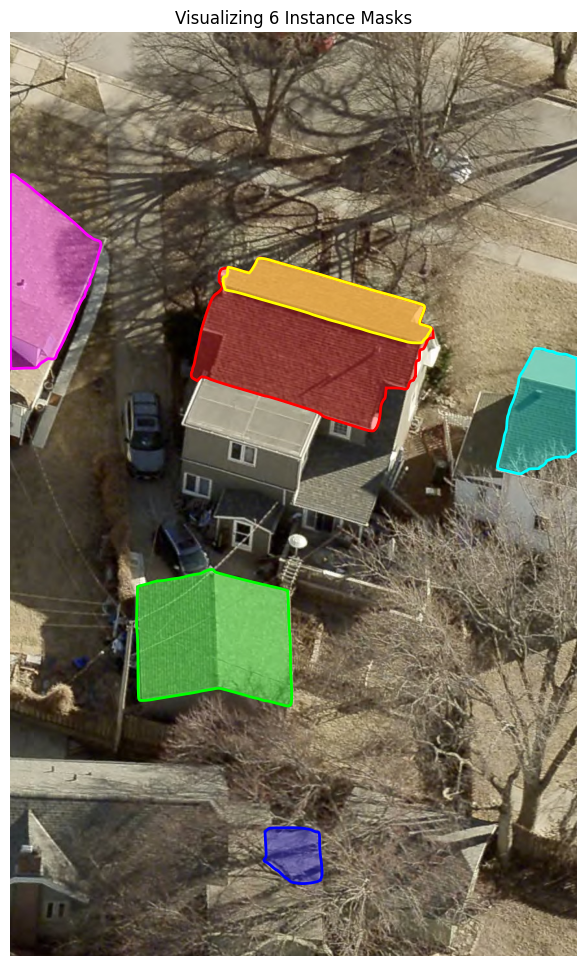

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random

IMAGE_PATH = "/content/image_1.jpg"

JSON_PATH = "/content/coco_annotations.json"

try:
    image = Image.open(IMAGE_PATH)
except FileNotFoundError:
    print(f"❌ Error: Could not find image at {IMAGE_PATH}")
    exit()

try:
    with open(JSON_PATH, 'r') as f:
        coco_data = json.load(f)
except FileNotFoundError:
    print(f"❌ Error: Could not find JSON file at {JSON_PATH}")
    exit()

fig, ax = plt.subplots(1, figsize=(12, 12))
ax.imshow(image)
ax.set_title(f"Visualizing {len(coco_data['annotations'])} Instance Masks")

colors = [
    '#FF0000', # Red
    '#00FF00', # Green
    '#0000FF', # Blue
    '#FFFF00', # Yellow
    '#FF00FF', # Magenta
    '#00FFFF', # Cyan
    '#FFA500', # Orange
    '#800080'  # Purple
]

print(f"Found {len(coco_data['annotations'])} annotations.")

for i, ann in enumerate(coco_data['annotations']):
    seg_points = ann['segmentation'][0]

    poly_coords = np.array(seg_points).reshape(-1, 2)

    color = colors[i % len(colors)]

    poly_patch = patches.Polygon(
        poly_coords,
        linewidth=2,
        edgecolor=color,
        facecolor=color + "50"
    )
    ax.add_patch(poly_patch)

    # Optional: Draw Bounding Box to verify alignment
    # bbox = ann['bbox'] # [x, y, w, h]
    # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
    #                          linewidth=1, edgecolor='white', facecolor='none', linestyle='--')
    # ax.add_patch(rect)

plt.axis('off')
plt.show()